In [1]:
from qiskit.circuit.library import QAOAAnsatz

import parity_network
import importlib
import numpy as np

This problem is a 4-sat with 4 qubits with one unique solution : 0110
<br>
(x₀ ∨ x₁ ∨ ¬x₂) ^ (x₀ ∨ ¬x₁ ∨ x₂) ^ (¬x₀ ∨ x₁ ∨ x₂) ^ (¬x₀ ∨ ¬x₁ ∨ ¬x₂) ^ (x₁ ∨ ¬x₂ ∨ x₃) ^ (¬x₁ ∨ x₂ ∨ x₃) ^ (¬x₁ ∨ ¬x₂ ∨ ¬x₃) ^ (¬x₀ ∨ ¬x₂ ∨ x₃) ^ (¬x₀ ∨ x₂ ∨ ¬x₃) ^ (x₀ ∨ ¬x₂ ∨ ¬x₃) ^ (x₀ ∨ x₂ ∨ x₃) ^ (¬x₀ ∨ ¬x₁ ∨ x₃) ^ (¬x₀ ∨ x₁ ∨ ¬x₃) ^ (x₀ ∨ ¬x₁ ∨ ¬x₃) ^ (x₀ ∨ x₁ ∨ x₃)

In [2]:
num_qubits = 4

In [3]:
from qiskit import QuantumCircuit


def cnot_count(circuit: QuantumCircuit) -> int:
    return circuit.count_ops().get("cx", 0)

In [4]:
importlib.reload(parity_network)

parity, term_dict = parity_network.main(num_qubits)

parity_ansatz = QAOAAnsatz(parity, reps=10)
parity_ansatz.measure_all()

# parity_ansatz.decompose().draw("mpl")

Parities and Weights of the Hamiltonian:
{'0000': 2.0, '1110': -0.5, '1101': 0.5, '1011': 0.5, '0111': -0.5}

Forward Circuit with Rz gates:
                                                                    
q_0: ──■──────────────────────────■─────────────────────────────────
     ┌─┴─┐                        │                                 
q_1: ┤ X ├──■──────────────■──────┼────────────────────■────────────
     └───┘┌─┴─┐┌────────┐  │    ┌─┴─┐                  │            
q_2: ─────┤ X ├┤ Rz(-γ) ├──┼────┤ X ├────■─────────────┼────────────
          └───┘└────────┘┌─┴─┐┌─┴───┴─┐┌─┴─┐┌───────┐┌─┴─┐┌────────┐
q_3: ────────────────────┤ X ├┤ Rz(γ) ├┤ X ├┤ Rz(γ) ├┤ X ├┤ Rz(-γ) ├
                         └───┘└───────┘└───┘└───────┘└───┘└────────┘

Return Journey Circuit:
               
q_0: ──■───────
     ┌─┴─┐     
q_1: ┤ X ├──■──
     └───┘┌─┴─┐
q_2: ──■──┤ X ├
     ┌─┴─┐└───┘
q_3: ┤ X ├─────
     └───┘     

Full Circuit:
global phase: 0
                                      

In [5]:
from qiskit.quantum_info import SparsePauliOp


def get_hamiltonian_observable(term_dict, n_qubits):
    # Converts a dictionary of bitstrings and weights into a Qiskit SparsePauliOp observable.
    pauli_list = []
    coeff_list = []
    for bitstring, weight in term_dict.items():
        pauli_str = ["I"] * n_qubits
        for i, bit in enumerate(bitstring):
            if bit == "1":
                pauli_str[n_qubits - 1 - i] = "Z"
        pauli_list.append("".join(pauli_str))
        coeff_list.append(weight)

    return SparsePauliOp(pauli_list, coeffs=coeff_list)

In [6]:
from scipy.optimize import minimize
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit.compiler import transpile

backend = AerSimulator()
estimator = AerEstimator()
estimator.options.shots = 10000

parity_ansatz_isa = transpile(parity_ansatz, backend=backend)

obs = get_hamiltonian_observable(term_dict, num_qubits)
print(obs)
print("CNOT count :", cnot_count(parity_ansatz_isa))

SparsePauliOp(['IIII', 'IZZZ', 'ZIZZ', 'ZZIZ', 'ZZZI'],
              coeffs=[ 2. +0.j, -0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])
CNOT count : 90


In [7]:
parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}


def initialize_cost_history_dict(cost_history_dict):
    cost_history_dict["iters"] = 0
    cost_history_dict["cost_history"] = []

In [8]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator, cost_history_dict):

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    cost_history_dict["iters"] += 1
    cost_history_dict["cost_history"].append(cost)
    print(f"Iters {cost_history_dict['iters']}: Current cost: {cost}")

    return cost

In [9]:
%%time
params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(parity_cost_history_dict)

result_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, estimator, parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 2.689453125
Iters 2: Current cost: 2.7509765625
Iters 3: Current cost: 3.25
Iters 4: Current cost: 3.08203125
Iters 5: Current cost: 2.1767578125
Iters 6: Current cost: 1.32421875
Iters 7: Current cost: 3.138671875
Iters 8: Current cost: 2.0966796875
Iters 9: Current cost: 1.44140625
Iters 10: Current cost: 2.07421875
Iters 11: Current cost: 2.0302734375
Iters 12: Current cost: 2.330078125
Iters 13: Current cost: 1.8251953125
Iters 14: Current cost: 2.189453125
Iters 15: Current cost: 1.828125
Iters 16: Current cost: 3.0478515625
Iters 17: Current cost: 1.419921875
Iters 18: Current cost: 1.1796875
Iters 19: Current cost: 2.3115234375
Iters 20: Current cost: 2.2392578125
Iters 21: Current cost: 0.865234375
Iters 22: Current cost: 2.634765625
Iters 23: Current cost: 1.154296875
Iters 24: Current cost: 1.0966796875
Iters 25: Current cost: 1.861328125
Iters 26: Current cost: 1.6318359375
Iters 27: Current cost: 0.50390625
Iters 28: Current cost: 2.994140625
Iters 29

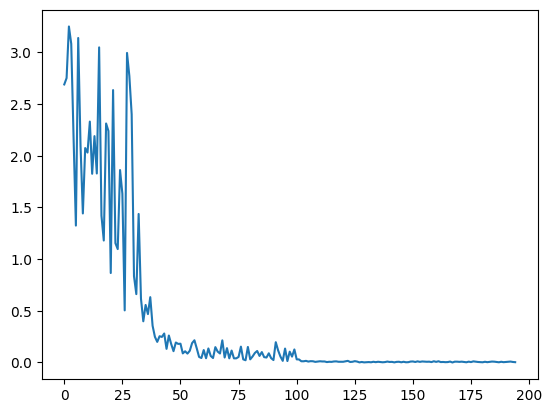

In [10]:
import matplotlib.pyplot as plt

plt.plot(parity_cost_history_dict["cost_history"])

In [11]:
naive_ansatz = QAOAAnsatz(obs, reps=10)
naive_ansatz.measure_all()

# naive_ansatz.decompose().draw("mpl")

In [12]:
naive_ansatz_isa = transpile(naive_ansatz, backend=backend)

print("CNOT count :", cnot_count(naive_ansatz_isa))

CNOT count : 140


In [13]:
naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],

}

In [14]:
%%time
params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(naive_cost_history_dict)

result_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, estimator, naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 2.6162109375
Iters 2: Current cost: 0.927734375
Iters 3: Current cost: 2.3857421875
Iters 4: Current cost: 0.7021484375
Iters 5: Current cost: 1.10546875
Iters 6: Current cost: 2.8486328125
Iters 7: Current cost: 2.814453125
Iters 8: Current cost: 2.861328125
Iters 9: Current cost: 3.095703125
Iters 10: Current cost: 2.6103515625
Iters 11: Current cost: 2.1103515625
Iters 12: Current cost: 1.4453125
Iters 13: Current cost: 0.9755859375
Iters 14: Current cost: 1.9326171875
Iters 15: Current cost: 2.599609375
Iters 16: Current cost: 2.91796875
Iters 17: Current cost: 2.259765625
Iters 18: Current cost: 1.6748046875
Iters 19: Current cost: 2.0556640625
Iters 20: Current cost: 2.30859375
Iters 21: Current cost: 2.3876953125
Iters 22: Current cost: 1.2998046875
Iters 23: Current cost: 1.0185546875
Iters 24: Current cost: 0.95703125
Iters 25: Current cost: 1.251953125
Iters 26: Current cost: 0.8974609375
Iters 27: Current cost: 0.6767578125
Iters 28: Current cost: 0.75

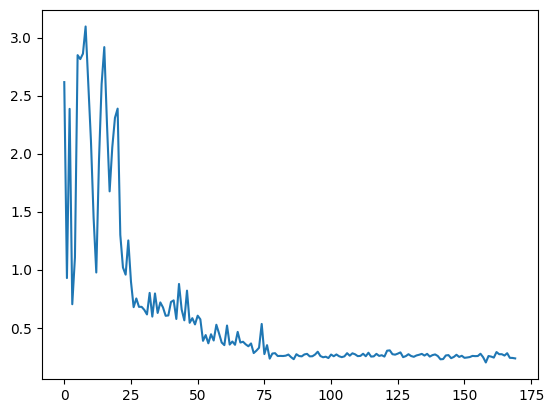

In [15]:
plt.plot(naive_cost_history_dict["cost_history"])

### Sampler

In [16]:
optimized_parity_ansatz = parity_ansatz_isa.assign_parameters(result_parity.x)

In [17]:
from qiskit_aer.primitives import SamplerV2 as AerSampler

sampler = AerSampler()
sampler.options.shots = 10000

parity_job = sampler.run([optimized_parity_ansatz])
parity_res = parity_job.result()


Most likely solution bitstring: 0110


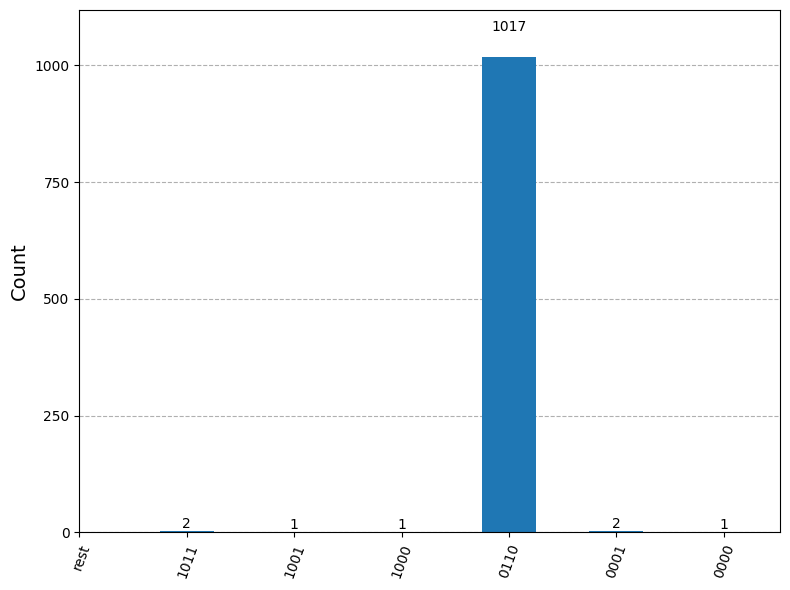

In [18]:
from qiskit.visualization import plot_histogram

counts = parity_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)
parity_sol = most_likely_bitstring

print(f"\nMost likely solution bitstring: {parity_sol}")
plot_histogram(counts)
plot_histogram(counts, number_to_keep=10, sort='desc', figsize=(8,6))

In [19]:
optimized_naive_ansatz = parity_ansatz_isa.assign_parameters(result_naive.x)


Most likely solution bitstring: 0110


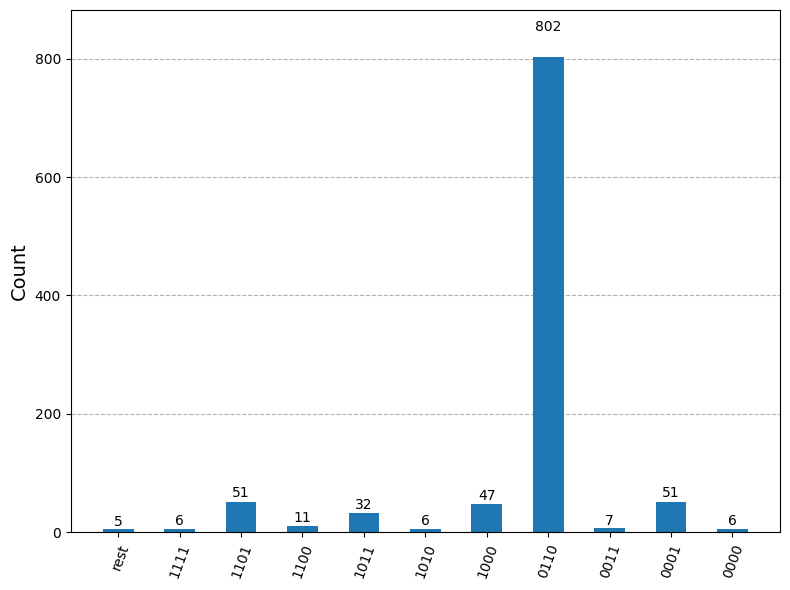

In [20]:
naive_job = sampler.run([optimized_naive_ansatz])
naive_res = naive_job.result()

counts = naive_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)
naive_sol = most_likely_bitstring

print(f"\nMost likely solution bitstring: {naive_sol}")
plot_histogram(counts, number_to_keep=10, sort='desc', figsize=(8,6))

### Noise AerSimulator

In [21]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

noisy_estimator = AerEstimator(
    options=dict(backend_options=dict(noise_model=noise_model))
)

In [22]:
noisy_parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [23]:
%%time

params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(noisy_parity_cost_history_dict)

result_noisy_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, noisy_estimator, noisy_parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 1.8515625
Iters 2: Current cost: 1.8271484375
Iters 3: Current cost: 1.84375
Iters 4: Current cost: 1.669921875
Iters 5: Current cost: 1.853515625
Iters 6: Current cost: 2.2470703125
Iters 7: Current cost: 1.810546875
Iters 8: Current cost: 1.8681640625
Iters 9: Current cost: 1.7158203125
Iters 10: Current cost: 1.9130859375
Iters 11: Current cost: 2.05078125
Iters 12: Current cost: 1.7197265625
Iters 13: Current cost: 1.85546875
Iters 14: Current cost: 1.9384765625
Iters 15: Current cost: 1.9765625
Iters 16: Current cost: 1.89453125
Iters 17: Current cost: 1.9033203125
Iters 18: Current cost: 1.966796875
Iters 19: Current cost: 2.021484375
Iters 20: Current cost: 1.916015625
Iters 21: Current cost: 2.0478515625
Iters 22: Current cost: 1.892578125
Iters 23: Current cost: 1.7373046875
Iters 24: Current cost: 1.7236328125
Iters 25: Current cost: 1.6962890625
Iters 26: Current cost: 1.6953125
Iters 27: Current cost: 1.69921875
Iters 28: Current cost: 1.748046875
Ite

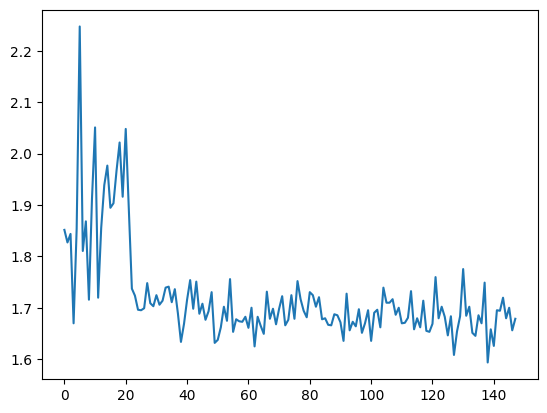

In [24]:
plt.plot(noisy_parity_cost_history_dict["cost_history"])

In [25]:
noisy_naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [26]:
%%time

params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(noisy_naive_cost_history_dict)

result_noisy_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, noisy_estimator, noisy_naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 1.9814453125
Iters 2: Current cost: 2.0400390625
Iters 3: Current cost: 1.9619140625
Iters 4: Current cost: 1.9091796875
Iters 5: Current cost: 2.0400390625
Iters 6: Current cost: 1.955078125
Iters 7: Current cost: 1.990234375
Iters 8: Current cost: 2.0244140625
Iters 9: Current cost: 2.099609375
Iters 10: Current cost: 2.0576171875
Iters 11: Current cost: 1.927734375
Iters 12: Current cost: 2.0634765625
Iters 13: Current cost: 1.90234375
Iters 14: Current cost: 1.875
Iters 15: Current cost: 1.9267578125
Iters 16: Current cost: 1.9580078125
Iters 17: Current cost: 1.9814453125
Iters 18: Current cost: 1.927734375
Iters 19: Current cost: 2.00390625
Iters 20: Current cost: 2.00390625
Iters 21: Current cost: 2.0673828125
Iters 22: Current cost: 1.892578125
Iters 23: Current cost: 2.0166015625
Iters 24: Current cost: 1.908203125
Iters 25: Current cost: 1.9521484375
Iters 26: Current cost: 1.8740234375
Iters 27: Current cost: 1.97265625
Iters 28: Current cost: 1.900390

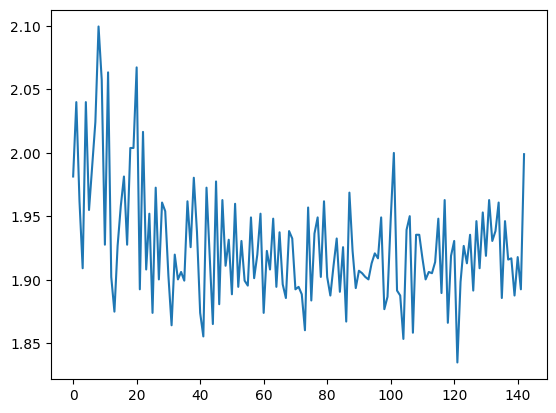

In [27]:
plt.plot(noisy_naive_cost_history_dict["cost_history"])

In [28]:
noisy_parity_ansatz_isa = parity_ansatz_isa
noisy_optimized_parity_ansatz = parity_ansatz_isa.assign_parameters(result_noisy_parity.x)

In [29]:
noisy_parity_job = sampler.run([noisy_optimized_parity_ansatz])
noisy_parity_res = noisy_parity_job.result()


Most likely solution bitstring: 0110


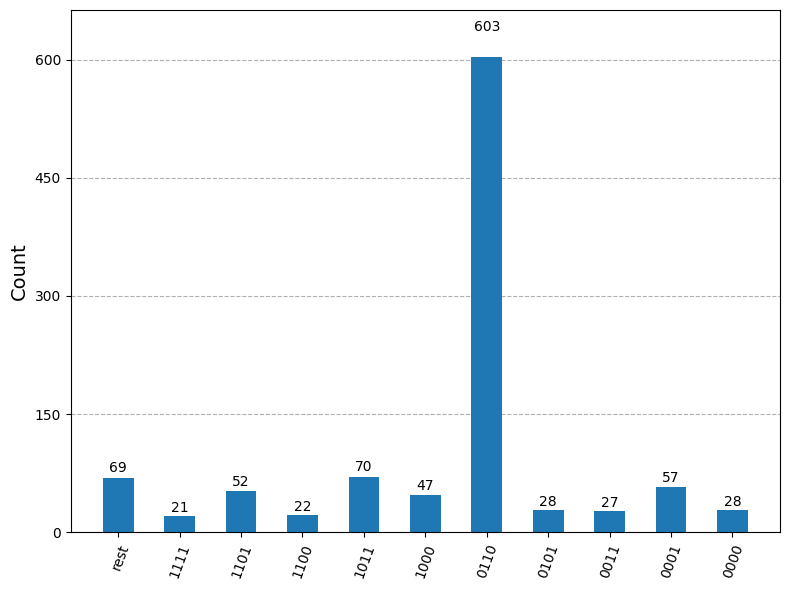

In [30]:
counts = noisy_parity_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)
noisy_parity_sol = most_likely_bitstring

print(f"\nMost likely solution bitstring: {noisy_parity_sol}")
plot_histogram(counts)
plot_histogram(counts, number_to_keep=10, sort='desc', figsize=(8,6))

In [31]:
noisy_naive_ansatz_isa = naive_ansatz_isa
noisy_optimized_naive_ansatz = naive_ansatz_isa.assign_parameters(result_noisy_naive.x)

In [32]:
noisy_naive_job = sampler.run([noisy_optimized_naive_ansatz])
noisy_naive_res = noisy_naive_job.result()


Most likely solution bitstring: 0110


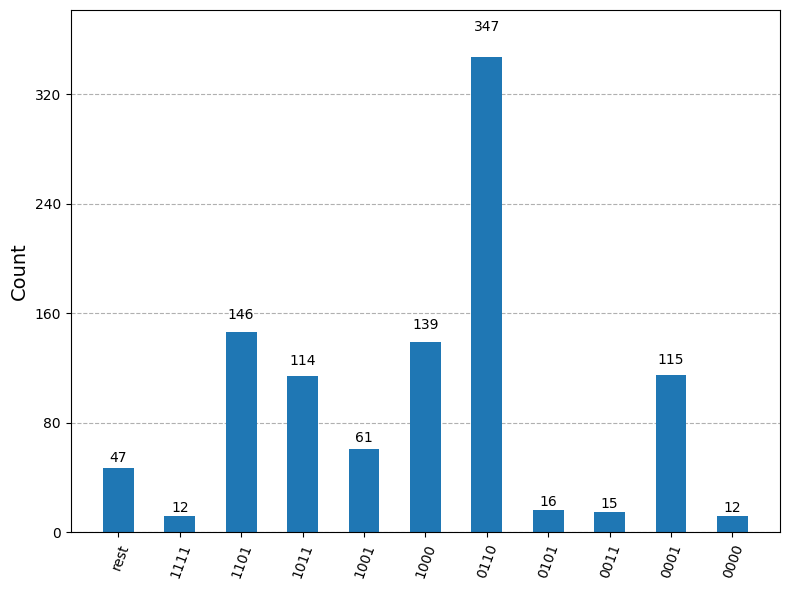

In [33]:
counts = noisy_naive_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)
noisy_naive_sol = most_likely_bitstring

print(f"\nMost likely solution bitstring: {noisy_naive_sol}")
plot_histogram(counts)
plot_histogram(counts, number_to_keep=10, sort='desc', figsize=(8,6))